In [89]:
# Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth
Had to go 0 folder(s) up.


In [ ]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources

added_network = os.getcwd() +  "/networks/elec.nc"
n_add = pypsa.Network(added_network) #network with electrical parameters added to components in data sources 

simplified_network = os.getcwd() +  "/networks/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = os.getcwd() + '/networks/elec_s_4.nc'
n_cluster = pypsa.Network(clustered_network) #network simplified based on number of clusters given

prepared_network = os.getcwd() + "/networks/elec_s_4_ec_lcopt_Co2L-1H.nc"
n_prepared = pypsa.Network(prepared_network) #network defined and ready for optimization

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc" 
#solved_network = r"C:\Users\Carlos\Desktop\PyPSA-BO\Results_analysis\EnergyScope-PyPSA\NZE scenario\elec_s_4_ec_lcopt_Co2L-1H.nc" #os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc" # or: solved_network = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\..........\elec_s_22_ec_lcopt_Co2L-1H.nc"
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\4155262218.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\4155262218.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


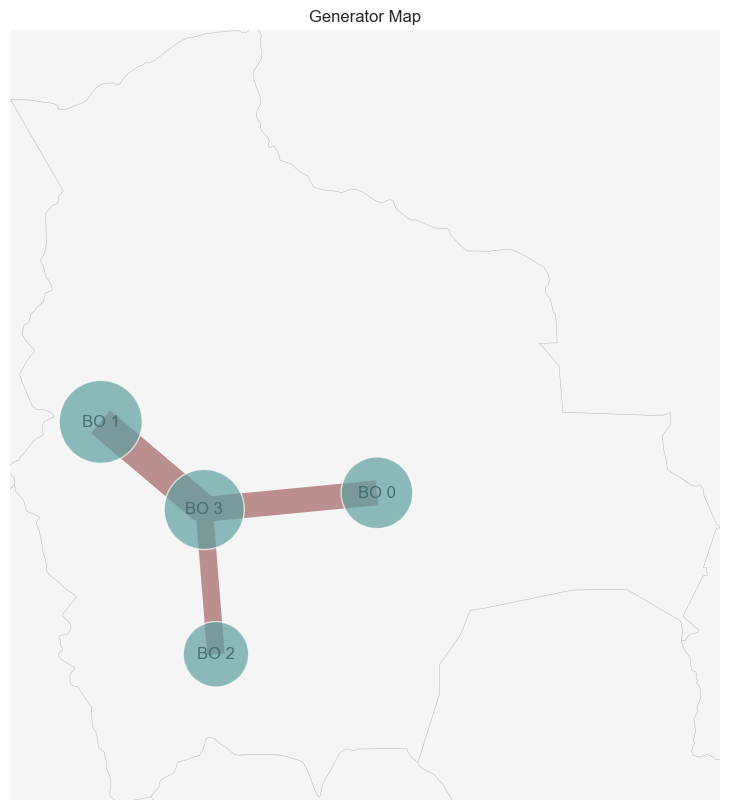

In [91]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

# Convert "Bus" index column to string type
filtered_buses = n.buses
filtered_buses.index = filtered_buses.index.astype(str)
filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
# Add bus names to the plot
for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
    ax.text(lon, lat, bus, fontsize=12, color='black', ha='center', va='center')

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [92]:
demand = n.loads_t.p_set.loc["2013-01-01":"2014-01-01"]
demand#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\demands.xlsx")

Load,BO 0,BO 1,BO 2,BO 3
snapshot,,,,
2013-01-01 00:00:00,1228.323510,1646.257413,1022.705344,1532.026045
2013-01-01 01:00:00,1098.353831,1472.065885,914.492251,1369.921410
2013-01-01 02:00:00,968.384271,1297.874519,806.279259,1207.816924
2013-01-01 03:00:00,935.497332,1253.797883,778.897507,1166.798701
2013-01-01 04:00:00,392.875890,526.550897,327.109486,490.014309
...,...,...,...,...
2013-12-31 19:00:00,1926.809793,2582.401849,1604.266836,2403.212802
2013-12-31 20:00:00,1539.756868,2063.655166,1282.005566,1920.461185
2013-12-31 21:00:00,1408.671734,1887.968653,1172.863743,1756.965300


In [93]:
reservoir = pd.DataFrame(n.storage_units.p_nom_opt)
reservoir#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\reservoir.xlsx")

,p_nom_opt
StorageUnit,
BO 0 hydro,400.00
BO 1 hydro,66.06
BO 2 hydro,353.46
BO 3 hydro,475.80


In [94]:
generators = pd.DataFrame(n.generators.p_nom_opt)
generators#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\generators.xlsx")

,p_nom_opt
Generator,
BO 0 CCGT,1.518924e+02
BO 0 OCGT,6.301066e+01
BO 0 biomass,6.621205e+02
BO 0 oil,1.363685e+02
BO 0 onwind,2.895460e+03
BO 0 solar,5.272220e-01
BO 1 CCGT,1.520021e+02
BO 1 OCGT,6.286712e+01
BO 1 biomass,8.844005e+02


In [95]:
# Fuel prices:
# gas,fuel,4.44,EUR/MWhth
# biomass,fuel,10.3,EUR/MWhth
# #oil,fuel,124.5,EUR/MWhth

<AxesSubplot:xlabel='snapshot'>

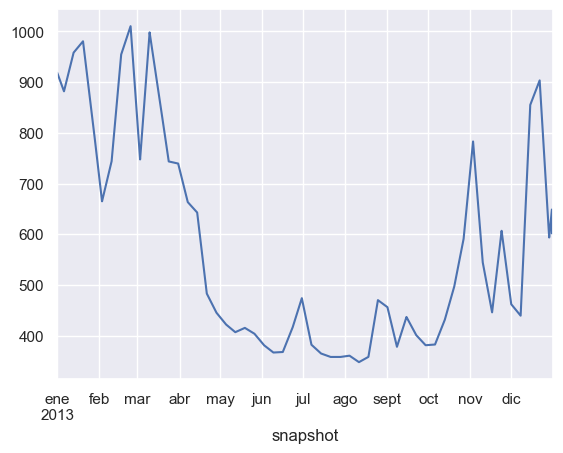

In [96]:
res_inflow_plot = n.storage_units_t.inflow.filter(like= "hydro").sum(axis=1)
res_inflow_plot.plot()

<AxesSubplot:xlabel='snapshot'>

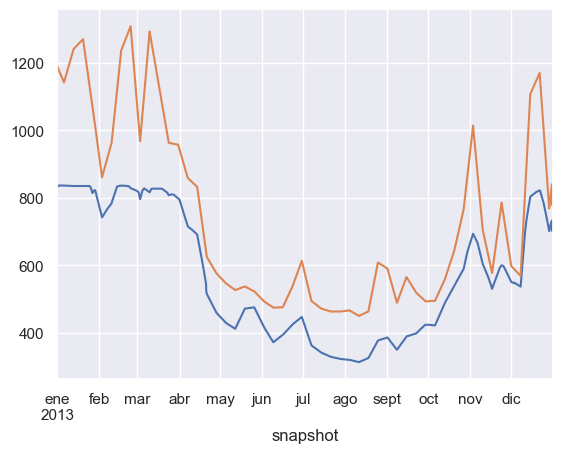

In [97]:
ror_inflow = n.generators_t.p_max_pu.filter(like="ror").mean(axis=1)*n.generators.p_nom_opt.filter(like= "ror").sum()
res_inflow = n.storage_units_t.inflow.filter(like= "hydro").sum(axis=1)*n.storage_units.p_nom_opt.filter(like= "hydro").sum()/1000
res_dispatch = n.storage_units_t.p.filter(like= "hydro").sum(axis=1)
ror_dispatch = n.generators_t.p.filter(like="ror").sum(axis=1)
ror_inflow#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\ror_inflow.xlsx")
res_inflow#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\res_inflow.xlsx")
ror_inflow.plot()
res_inflow.plot()
#res_dispatch.plot()
#ror_dispatch.plot()

In [98]:
spillage = n.storage_units_t.spill
spillage.sum()

StorageUnit
BO 0 hydro    81.246559
BO 1 hydro    58.414097
BO 2 hydro    96.893285
BO 3 hydro    80.058605
dtype: float64

In [99]:
lines = n.lines.loc[:,["bus0","bus1","s_nom_opt"]]
lines#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\lines.xlsx")

,bus0,bus1,s_nom_opt
Line,,,
1,BO 0,BO 3,1796.822223
2,BO 1,BO 3,2141.721512
3,BO 2,BO 3,1254.492445


In [100]:
stores = n.stores.e_nom_opt
stores#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\storage.xlsx")

Store
BO 0 battery      36.431769
BO 1 battery     717.995554
BO 2 battery    1853.181906
BO 3 battery    4631.390666
Name: e_nom_opt, dtype: float64

In [101]:
generators_variables = n.generators.drop(columns=["p_nom_max","weight","capital_cost","p_nom_min","marginal_cost","p_nom","p_nom_extendable","control","sign","build_year","p_min_pu","p_max_pu","marginal_cost_quadratic","lifetime","p_set","q_set","type","committable"])
generators_variables = generators_variables[~generators_variables.index.str.contains("load")]
generators_variables#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset\variables_generators.xlsx")

,efficiency,bus,carrier,p_nom_opt,min_up_time,min_down_time,up_time_before,down_time_before,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,
BO 0 CCGT,0.4695,BO 0,CCGT,151.892369,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 OCGT,0.3246,BO 0,OCGT,63.010664,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 biomass,0.2966,BO 0,biomass,662.120526,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 oil,0.3690,BO 0,oil,136.368454,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,1.0000,BO 0,onwind,2895.460398,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,1.0000,BO 0,solar,0.527222,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,0.4695,BO 1,CCGT,152.002098,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,0.3246,BO 1,OCGT,62.867117,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 biomass,0.2966,BO 1,biomass,884.400485,0,0,1,0,0.0,0.0,NaN,NaN,1.0,1.0


In [102]:
#average capacity factor
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()
for i in capacity_factor.index:
    if capacity_factor.loc[i, 'onwind'] > 1: capacity_factor.loc[i, 'onwind'] = 1
    if capacity_factor.loc[i, 'solar'] > 1: capacity_factor.loc[i, 'solar'] = 1 

capacity_factor['onwind']#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\capacity_factor_wind.xlsx")
capacity_factor['solar']#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\capacity_factor_solar.xlsx")

C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\1463142213.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()


snapshot
2013-01-01 00:00:00    0.000000
2013-01-01 01:00:00    0.000000
2013-01-01 02:00:00    0.000000
2013-01-01 03:00:00    0.000000
2013-01-01 04:00:00    0.000000
                         ...   
2013-12-31 19:00:00    0.495971
2013-12-31 20:00:00    0.398566
2013-12-31 21:00:00    0.253255
2013-12-31 22:00:00    0.115232
2013-12-31 23:00:00    0.010458
Name: solar, Length: 8760, dtype: float64

In [103]:
cols = "onwind"
generation = n.generators_t.p.loc["2013-01-01":"2014-01-01"].filter(regex=cols)
real_CP= generation.sum().sum()/(n.generators.p_nom_opt.filter(like=cols).sum()*8760)
real_CP

0.26294260762416477

In [104]:
cols = "onwind"
potential_gen = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex=cols) * n.generators.loc[[idx for idx in n.generators.index if cols in idx]]['p_nom_opt']
max_CP= potential_gen.sum().sum()/(n.generators.p_nom_opt.filter(like=cols).sum()*8760)
max_CP

0.35185278013404075

In [105]:
potential_gen.max()

Generator
BO 0 onwind    6553.271523
BO 1 onwind       0.167090
BO 2 onwind     768.124339
BO 3 onwind       0.305115
dtype: float64

In [106]:
#normalized capacity factor Wind
wind_cp = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex="onwind")
for i in wind_cp.index:
    for j in wind_cp.columns:
        if wind_cp.loc[i,j] > 1: wind_cp.loc[i,j] = 1

wind_cp#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\wind_cp_per_bus.xlsx")

Generator,BO 0 onwind,BO 1 onwind,BO 2 onwind,BO 3 onwind
snapshot,,,,
2013-01-01 00:00:00,0.785108,0.234270,0.498652,0.103320
2013-01-01 01:00:00,0.804022,0.249312,0.477974,0.150237
2013-01-01 02:00:00,0.803728,0.241520,0.415520,0.166670
2013-01-01 03:00:00,0.823715,0.232781,0.341044,0.119598
2013-01-01 04:00:00,0.822487,0.228037,0.268313,0.080270
...,...,...,...,...
2013-12-31 19:00:00,1.000000,0.313350,0.081213,0.086179
2013-12-31 20:00:00,1.000000,0.235965,0.127064,0.113983
2013-12-31 21:00:00,1.000000,0.209749,0.188126,0.101603


In [107]:
#normalized capacity factor Solar
solar_cp = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex="solar")
for i in solar_cp.index:
    for j in solar_cp.columns:
        if solar_cp.loc[i,j] > 1: solar_cp.loc[i,j] = 1

solar_cp#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\solar_cp_per_bus.xlsx")

Generator,BO 0 solar,BO 1 solar,BO 2 solar,BO 3 solar
snapshot,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
2013-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2013-12-31 19:00:00,0.467258,0.470854,0.549681,0.496091
2013-12-31 20:00:00,0.418180,0.374581,0.411039,0.390466
2013-12-31 21:00:00,0.247592,0.247929,0.261509,0.255992


In [108]:
cps_wind = wind_cp * n.generators.loc[[idx for idx in n.generators.index if "onwind" in idx]]['p_nom_opt']/(n.generators.p_nom_opt.filter(like="onwind").sum())
cps_solar = solar_cp * n.generators.loc[[idx for idx in n.generators.index if "solar" in idx]]['p_nom_opt']/(n.generators.p_nom_opt.filter(like="solar").sum())

cps_wind.sum(axis=1)#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\wind_cp_average_National.xlsx")
cps_solar.sum(axis=1)#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2024\Articulos y publicaciones\ECEMP\inputs dispaset NZE\solar_cp_average_National.xlsx")


snapshot
2013-01-01 00:00:00    0.000000
2013-01-01 01:00:00    0.000000
2013-01-01 02:00:00    0.000000
2013-01-01 03:00:00    0.000000
2013-01-01 04:00:00    0.000000
                         ...   
2013-12-31 19:00:00    0.500939
2013-12-31 20:00:00    0.391110
2013-12-31 21:00:00    0.255416
2013-12-31 22:00:00    0.118281
2013-12-31 23:00:00    0.016537
Length: 8760, dtype: float64

In [109]:
n.generators.loc[[idx for idx in n.generators.index if cols in idx]]['p_nom_opt']

Generator
BO 0 onwind    2895.460398
BO 1 onwind       0.102724
BO 2 onwind     401.301080
BO 3 onwind       0.158978
Name: p_nom_opt, dtype: float64

In [110]:
n.lines

,bus0,bus1,length,carrier,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 3,391.342503,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,14914.867035,2.090909,True,616.389645,71.122246,17.761845,0.002365,0,0.001344,0.000336,1796.822223,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 1,BO 3,312.606737,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,11911.514261,2.090909,True,616.389645,56.812876,14.188268,0.001889,0,0.001074,0.000268,2141.721512,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 2,BO 3,343.809330,AC,305-AL1/39-ST1A 110.0,0.7,633.331306,13101.492689,2.246032,True,662.119093,58.168160,14.526733,0.002232,0,0.001100,0.000275,1254.492445,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [ ]:
first_date = "2013-01-01"
second_date = "2014-01-01"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar.loc[first_date:second_date] + curtailment_wind.loc[first_date:second_date]
curtailment.name = "curtailment"

#Hourly generation per technology
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
demand.name = "demand"

size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
reservoir.name = "reservoir"

#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery = []
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

i=0
nH2 = []
pH2 = []
for i in H2:
    if i < 0:
        nH2.append(i)
    else:
        nH2.append(0) 
for i in H2:
    if i > 0:
        pH2.append(i)
    else:
        pH2.append(0) 

# Concatenate all data into dataframes
base_index = solar.index
pbattery = pd.Series(pbattery, index=base_index, name="pbattery")
pH2 = pd.Series(pH2, index=base_index, name="pH2")
nbattery = pd.Series(nbattery, index=base_index, name="nbattery")
nH2 = pd.Series(nH2, index=base_index, name="nH2")


dispatch_sets = [OCGT, CCGT, Onwind, solar, curtailment, ror,reservoir, pbattery, oil, biomass, geothermal] #, pH2, load
Total_dispatch = pd.concat(dispatch_sets, axis=1)

demand_sets = [demand, nbattery] #, nH2
Total_demand = pd.concat(demand_sets,axis=1)

Total_demand.min()#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2025\Articulos y publicaciones\ER_Energy - ECEMP 2024\inputs dispaset EPI\hourly_demand.xlsx")
Total_dispatch.max()#.to_excel(r"C:\Users\Carlos\OneDrive - Universite de Liege\Documents\2025\Articulos y publicaciones\ER_Energy - ECEMP 2024\inputs dispaset EPI\hourly_dispatch.xlsx")


C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\278220311.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\278220311.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\278220311.py:20: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_34632\278220311.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. D

OCGT          2013-06-10 11:00:00
CCGT          2013-06-10 11:00:00
onwind        2013-07-22 13:00:00
solar         2013-09-03 17:00:00
curtailment   2013-07-20 17:00:00
ror           2013-02-18 10:00:00
reservoir     2013-06-10 13:00:00
pbattery      2013-07-12 12:00:00
oil           2013-06-10 11:00:00
biomass       2013-06-10 13:00:00
geothermal    2013-06-07 10:00:00
dtype: datetime64[ns]